Bibliothèques importées avec succès.
Version de TensorFlow : 2.19.0
Aucun GPU trouvé. L'entraînement s'effectuera sur le CPU, ce qui sera plus lent.
Données d'entraînement, de validation, de test et mappings chargés avec succès.
Train DataFrame shape: (25600162, 6)
Validation DataFrame shape: (3200021, 6)
Test DataFrame shape: (3200021, 6)
Nombre d'utilisateurs mappés : 200948
Nombre de films mappés : 84432

Données préparées pour l'entraînement du modèle Deep Learning.
Exemple de données d'entraînement : user_id=126341, movie_id=48, rating=4.0

--- Architecture du modèle de Deep Learning ---


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 50)     │ 10,047,450 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_embedding     │ (None, 1, 50)     │  4,221,650 │ movie_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_flatten        │ (None, 50)        │          0 │ user_embedding[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_flatten       │ (None, 50)        │          0 │ movie_embedding[… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_embedd… │ (None, 100)       │          0 │ user_flatten[0][… │
│ (Concatenate)       │                   │            │ movie_flatten[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     12,928 │ concatenate_embe… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │      2,080 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_rating       │ (None, 1)         │         33 │ dense_3[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,292,397 (54.52 MB)

 Trainable params: 14,292,397 (54.52 MB)

 Non-trainable params: 0 (0.00 B)


--- Début de l'entraînement du modèle ---
Epoch 1/10
50001/50001 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.8247 - mae: 0.6811
Epoch 1: val_loss improved from None to 0.66297, saving model to ../data/deeprec_model.keras
50001/50001 ━━━━━━━━━━━━━━━━━━━━ 4477s 89ms/step - loss: 0.7239 - mae: 0.6438 - val_loss: 0.6630 - val_mae: 0.6131
Epoch 2/10
50001/50001 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.6428 - mae: 0.6042
Epoch 2: val_loss improved from 0.66297 to 0.63352, saving model to ../data/deeprec_model.keras
50001/50001 ━━━━━━━━━━━━━━━━━━━━ 4098s 82ms/step - loss: 0.6292 - mae: 0.5968 - val_loss: 0.6335 - val_mae: 0.5978
Epoch 3/10
50001/50001 ━━━━━━━━━━━━━━━━━━━━ 0s 855ms/step - loss: 0.5895 - mae: 0.5745
Epoch 3: val_loss improved from 0.63352 to 0.62489, saving model to ../data/deeprec_model.keras
50001/50001 ━━━━━━━━━━━━━━━━━━━━ 42763s 855ms/step - loss: 0.5793 - mae: 0.5687 - val_loss: 0.6249 - val_mae: 0.5931
Epoch 4/10
50001/50001 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0

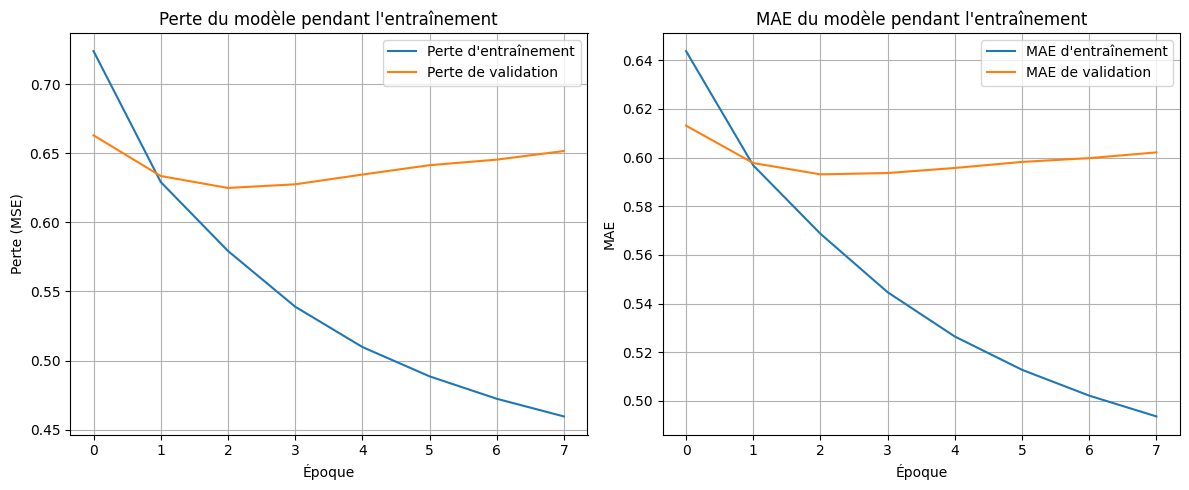


--- Évaluation du modèle sur l'ensemble de test ---
100001/100001 ━━━━━━━━━━━━━━━━━━━━ 206s 2ms/step
RMSE (Deep Learning Model) sur l'ensemble de test : 0.7905
MAE (Deep Learning Model) sur l'ensemble de test : 0.5935

Prédictions du modèle Deep Learning sauvegardées sous '../data/dl_predictions.csv'.

--- Entraînement et évaluation du modèle Deep Learning terminés ! ---


In [1]:
# -*- coding: utf-8 -*-
"""
# 3_DeepLearning_Model_Training.ipynb

Ce notebook est dédié à la construction, à l'entraînement et à l'évaluation
d'un modèle de recommandation basé sur les réseaux neuronaux profonds (Deep Learning).
Nous utiliserons TensorFlow/Keras pour implémenter une architecture de type
Neural Collaborative Filtering (NCF) simplifiée.
"""

# 1. Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns

print("Bibliothèques importées avec succès.")
print(f"Version de TensorFlow : {tf.__version__}")

# --- Vérification et configuration du GPU ---
# L'entraînement des modèles de Deep Learning est considérablement plus rapide sur un GPU.
# Cette section vérifie si un GPU est disponible et l'utilise si c'est le cas.
try:
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        # Configurer TensorFlow pour utiliser le GPU
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("GPU trouvé et configuré :", gpus[0])
    else:
        print("Aucun GPU trouvé. L'entraînement s'effectuera sur le CPU, ce qui sera plus lent.")
except RuntimeError as e:
    # Peut survenir si un GPU est présent mais a des problèmes
    print(e)

# Assurer la reproductibilité
tf.random.set_seed(42)
np.random.seed(42)

# 2. Chargement des données prétraitées et des mappings
try:
    train_df = pd.read_csv('../data/train_ratings.csv')
    val_df = pd.read_csv('../data/val_ratings.csv')
    test_df = pd.read_csv('../data/test_ratings.csv')

    user_to_id = np.load('../data/user_to_id.npy', allow_pickle=True).item()
    id_to_user = np.load('../data/id_to_user.npy', allow_pickle=True).item()
    movie_to_id = np.load('../data/movie_to_id.npy', allow_pickle=True).item()
    id_to_movie = np.load('../data/id_to_movie.npy', allow_pickle=True).item()

    print("Données d'entraînement, de validation, de test et mappings chargés avec succès.")
    print(f"Train DataFrame shape: {train_df.shape}")
    print(f"Validation DataFrame shape: {val_df.shape}")
    print(f"Test DataFrame shape: {test_df.shape}")

except FileNotFoundError:
    print("Erreur : Les fichiers de données ou de mappings n'ont pas été trouvés.")
    print("Assure-toi d'avoir exécuté le notebook '1_EDA_Preprocessing.ipynb' au préalable.")
    exit()

# Déterminer le nombre total d'utilisateurs et de films mappés
n_users_mapped = len(user_to_id)
n_movies_mapped = len(movie_to_id)
print(f"Nombre d'utilisateurs mappés : {n_users_mapped}")
print(f"Nombre de films mappés : {n_movies_mapped}")

# 3. Préparation des données pour TensorFlow/Keras
# Les modèles Keras attendent des tableaux NumPy comme entrées.
X_train_users = train_df['user_id_mapped'].values
X_train_movies = train_df['movie_id_mapped'].values
y_train = train_df['rating'].values

X_val_users = val_df['user_id_mapped'].values
X_val_movies = val_df['movie_id_mapped'].values
y_val = val_df['rating'].values

X_test_users = test_df['user_id_mapped'].values
X_test_movies = test_df['movie_id_mapped'].values
y_test = test_df['rating'].values

print("\nDonnées préparées pour l'entraînement du modèle Deep Learning.")
print(f"Exemple de données d'entraînement : user_id={X_train_users[0]}, movie_id={X_train_movies[0]}, rating={y_train[0]}")

# 4. Construction du modèle de Deep Learning (NCF simplifié)
# L'idée est d'apprendre des embeddings (représentations vectorielles denses) pour chaque utilisateur et chaque film,
# puis de les combiner et de les passer à travers un réseau de neurones pour prédire la note.

# Dimensions des embeddings
embedding_dim = 50 # Une taille courante pour les embeddings

# Entrée pour les IDs d'utilisateurs
user_input = Input(shape=(1,), name='user_input')
# Couche d'embedding pour les utilisateurs
# input_dim = nombre total d'utilisateurs uniques + 1 (pour gérer les IDs de 0 à N-1)
user_embedding = Embedding(input_dim=n_users_mapped + 1, output_dim=embedding_dim, name='user_embedding')(user_input)
user_vec = Flatten(name='user_flatten')(user_embedding) # Aplatir l'embedding

# Entrée pour les IDs de films
movie_input = Input(shape=(1,), name='movie_input')
# Couche d'embedding pour les films
movie_embedding = Embedding(input_dim=n_movies_mapped + 1, output_dim=embedding_dim, name='movie_embedding')(movie_input)
movie_vec = Flatten(name='movie_flatten')(movie_embedding) # Aplatir l'embedding

# Concaténer les vecteurs d'embeddings utilisateur et film
concat = Concatenate(name='concatenate_embeddings')([user_vec, movie_vec])

# Couches denses (MLP)
# Ces couches apprennent des interactions non linéaires entre les embeddings
dense_1 = Dense(128, activation='relu', name='dense_1')(concat)
dense_2 = Dense(64, activation='relu', name='dense_2')(dense_1)
dense_3 = Dense(32, activation='relu', name='dense_3')(dense_2)

# Couche de sortie
# Une seule neurone pour prédire la note. Pas d'activation pour une régression directe,
# ou sigmoid si on veut compresser la sortie entre 0 et 1 puis scaler.
# Ici, nous allons prédire directement la note.
output = Dense(1, activation=None, name='output_rating')(dense_3)

# Créer le modèle
model = Model(inputs=[user_input, movie_input], outputs=output)

# Compiler le modèle
# Utilisation de l'optimiseur Adam et de l'erreur quadratique moyenne (MSE) comme fonction de perte.
# Nous suivrons aussi le MAE.
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

print("\n--- Architecture du modèle de Deep Learning ---")
model.summary()

# 5. Entraînement du modèle
# Utilisation de Callbacks pour améliorer l'entraînement :
# - EarlyStopping: Arrête l'entraînement si la performance sur l'ensemble de validation ne s'améliore plus.
# - ModelCheckpoint: Sauvegarde le meilleur modèle (basé sur la performance de validation).

early_stopping = EarlyStopping(
    monitor='val_loss', # Surveiller la perte sur l'ensemble de validation
    patience=5,          # Attendre 5 époques sans amélioration avant d'arrêter
    restore_best_weights=True # Restaurer les poids du meilleur modèle trouvé
)

# Nous utilisons maintenant le format natif Keras (.keras) pour la sauvegarde
model_checkpoint = ModelCheckpoint(
    filepath='../data/deeprec_model.keras', # Chemin pour sauvegarder le modèle
    monitor='val_loss',
    save_best_only=True, # Sauvegarder uniquement le meilleur modèle
    verbose=1
)

print("\n--- Début de l'entraînement du modèle ---")
history = model.fit(
    [X_train_users, X_train_movies], # Entrées pour les utilisateurs et les films
    y_train,                         # Notes réelles
    epochs=10,                       # Nombre maximal d'époques réduit pour un test rapide
    batch_size=512,                  # Taille du batch augmentée pour accélérer l'entraînement
    validation_data=([X_val_users, X_val_movies], y_val), # Données de validation
    callbacks=[early_stopping, model_checkpoint], # Utilisation des callbacks
    verbose=1
)
print("\n--- Entraînement du modèle terminé ! ---")

# 6. Visualisation de l'historique d'entraînement
print("\n--- Visualisation de l'historique d'entraînement ---")

# Plot de la perte (loss)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Perte d\'entraînement')
plt.plot(history.history['val_loss'], label='Perte de validation')
plt.title('Perte du modèle pendant l\'entraînement')
plt.xlabel('Époque')
plt.ylabel('Perte (MSE)')
plt.legend()
plt.grid(True)

# Plot de la MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='MAE d\'entraînement')
plt.plot(history.history['val_mae'], label='MAE de validation')
plt.title('MAE du modèle pendant l\'entraînement')
plt.xlabel('Époque')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 7. Évaluation du modèle sur l'ensemble de test
print("\n--- Évaluation du modèle sur l'ensemble de test ---")

# Charger le meilleur modèle sauvegardé par ModelCheckpoint
# Nous chargeons maintenant le fichier au format .keras
best_model = tf.keras.models.load_model('../data/deeprec_model.keras')

# Faire des prédictions sur l'ensemble de test
predictions_dl = best_model.predict([X_test_users, X_test_movies])

# Les prédictions sont des tableaux NumPy, aplatissons-les si nécessaire
predictions_dl = predictions_dl.flatten()

# S'assurer que les prédictions sont dans la plage des notes (1 à 5)
predictions_dl = np.clip(predictions_dl, 1.0, 5.0)

# Calcul des métriques RMSE et MAE
rmse_dl = sqrt(mean_squared_error(y_test, predictions_dl))
mae_dl = mean_absolute_error(y_test, predictions_dl)

print(f"RMSE (Deep Learning Model) sur l'ensemble de test : {rmse_dl:.4f}")
print(f"MAE (Deep Learning Model) sur l'ensemble de test : {mae_dl:.4f}")

# Sauvegarder les prédictions pour une analyse future si nécessaire
pd.DataFrame({
    'user_id_mapped': X_test_users,
    'movie_id_mapped': X_test_movies,
    'true_rating': y_test,
    'predicted_rating_dl': predictions_dl
}).to_csv('../data/dl_predictions.csv', index=False)
print("\nPrédictions du modèle Deep Learning sauvegardées sous '../data/dl_predictions.csv'.")

print("\n--- Entraînement et évaluation du modèle Deep Learning terminés ! ---")